# Dataset visualization Tutorial 📊

This notebook demonstrates how to work with an example project using the datamint library. You'll learn how to load data, visualize images and segmentations, and work with both multi-frame and single-frame approaches.

## Table of Contents
- [Setup](#setup) 🛠️
- [Data Loading](#data-loading) 📥
- [Exploring Dataset Structure](#exploring-dataset-structure) 🔍
- [Visualizing Images](#visualizing-images) 🖼️
- [Visualizing Segmentations](#visualizing-segmentations) 🖼️
- [Frame-by-Frame Loading](#frame-by-frame-loading) 🎞️

# Setup 🛠️

Update your datamint package to the latest version, if you haven't already:

In [ ]:
%pip install -U datamint --quiet

configure your API key with the command-line tool: (see [Setup API key](https://sonanceai.github.io/datamint-python-api/setup_api_key.html) for other methods)

In [ ]:
!datamint-config --api-key <YOUR_API_KEY_HERE>

API key saved.                                                                  


## Setup-up example Project and data (optional)

You can skip this step if you already have a project set up.

Creating the example project:

In [ ]:
from datamint.examples import ProjectMR

PROJECT_NAME = 'Example Project MR'

proj = ProjectMR.create(project_name=PROJECT_NAME,
                        with_annotations=True)
print(f"Check your project at {proj.url}")

## Get existing Project

In [ ]:
from datamint import Api

PROJECT_NAME = 'My Project Name'  # change to your project name

api = Api()
proj = api.projects.get_by_name(PROJECT_NAME)  # proj is a Project object with proper attributes and type hints
if proj is None:
    _LOGGER.error(f"Project with name '{PROJECT_NAME}' not found.")
else:
    # but you can convert to a dictionary if you want
    display(proj.asdict())

# Data loading 📥

Lets first define the data which we want to download.

In [ ]:
from datamint import Dataset

D = Dataset(
    project_name=PROJECT_NAME,
    return_as_semantic_segmentation=True,
    all_annotations=True
) # This automatically downloads the dataset if needed
print('Dataset length:', len(D))

# Exploring Dataset Structure 🔍

With the data downloaded, lets access an item in the dataset and plot it.

In [2]:
item = D[0] # the first item

img = item['image'] # this access image. Shape: (#frames, #channels, height, width)
frame_labels = item['frame_labels']
image_labels = item['image_labels']
segmentations = item['segmentations']
seglabels = item['seg_labels']

print('Image.shape:', img.shape)

Image.shape: torch.Size([10, 1, 64, 64])


you can get more advanced information from the 'metainfo' attribute:

In [3]:
item['metainfo'].keys() # dictionary with metadata about the resource

dict_keys(['id', 'resource_uri', 'storage', 'location', 'upload_channel', 'filename', 'modality', 'mimetype', 'size', 'upload_mechanism', 'customer_id', 'status', 'created_at', 'created_by', 'published', 'deleted', 'source_filepath', 'metadata', 'projects', 'published_on', 'published_by', 'tags', 'publish_transforms', 'deleted_at', 'deleted_by', 'instance_uid', 'series_uid', 'study_uid', 'patient_id', 'segmentations', 'measurements', 'categories', 'user_info', 'labels', 'file'])

# Visualizing Images 🖼️

Note that the image is a tensor of 4 dimensions where the first dimension is the number of frames. The shape is (#frames, #channels, height, width). Lets plot the second frame:

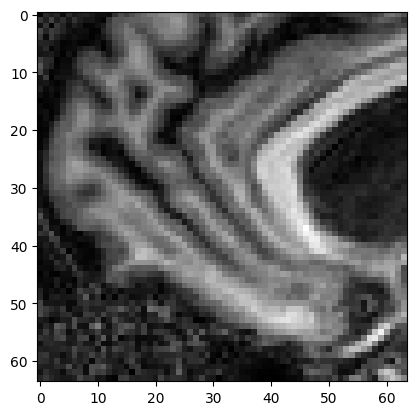

In [4]:
from matplotlib import pyplot as plt

plt.imshow(img[1, 0], cmap='gray')  # img[1, 0] means the second frame, first channel

Lets plot segmentations. But first, lets check the shape of the segmentations:

In [5]:
segmentations = item['segmentations']
# segmentations is a dict mapping an author to a Tensor of shape (#frames, #labels+background, height, width)
{k: v.shape for k, v in segmentations.items()}

{}

Note that `segmentations` has one key for each author. Each author contains a tensor of shape (#frames, height, width). The segmentation is a binary mask where 1 indicates the presence of an object in the frame.

For instance, `segmentations['lucas@mail.com'][0,2]` is the segmentation mask of the **second** class for the **first** frame of author 'lucas@mail.com'. 

<div class="alert alert-block alert-info"> 
<b>🛈 NOTE:</b> Index 0 represents the background class. This means that when accessing segmentation masks, the first index is reserved for the background, and actual semantic classes start from index 1.
</div>

Let's plot one of the segmentations:

# Visualizing Segmentations 🖼️

In [8]:
segmentations

{}

In [6]:
my_segs = segmentations['lucas@mail.com']
seg_mask_i = my_segs[1, 1]  # second frame, first label ([1,0] is background)
label_name = D.segmentation_labels_set[0]  # Note: segmentation_labels_set does not include background.
plt.imshow(seg_mask_i, cmap='gray')
plt.title(label_name);

KeyError: 'lucas@mail.com'

Plot them together:


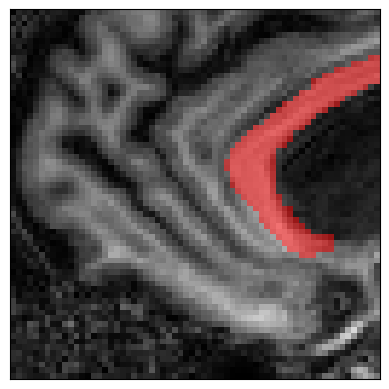

In [10]:
from datamint.utils.visualization import draw_masks, show

show(draw_masks(image=img[1], # second frame
                masks=my_segs[1, 1:]) # `1:` to skip background mask
     )

# Frame-by-Frame Loading 🎞️

Instead of loading all the frames of the dicom, we can load one frame at a time. This is done by setting `return_frame_by_frame=True` in the `__init__` method of the `Dataset`:

In [ ]:
from datamint import Dataset

D = Dataset(
    project_name=PROJECT_NAME,
    return_as_semantic_segmentation=True,
    return_frame_by_frame=True,
) # This automatically downloads the dataset if needed
print('Dataset length:', len(D))

Dataset length: 10


We now have a dataset length of 10 instead of 1, because all its frames were unpacked.  
Also, the shape returned by `D[0]['image']` is (#channels, height, width) instead of (#frames, #channels, height, width):

In [10]:
D[0]['image'].shape

torch.Size([1, 64, 64])